In [140]:
# Librerias necesarias
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import plotly.graph_objects as go
import plotly.express as px
import datetime as dt

from scipy import stats #para estandarizar los datos
from scipy.spatial import distance_matrix #calculo de la matriz de distancia
from sklearn.cluster import KMeans #calculo del cluster k-media

# Configuracion de pandas para que no bloque asignaciones masivas
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_excel("../data/Online_Retail_Limpia.xlsx")
df.head()

,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Amount_Spent,CustomerID,Country,Month,Year,Quarter,Semana,DiaSemana,Dia,NombreDia,Date,Yearmonth,Hour
0,536365,2010-12-01 08:26:00,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,17850,United Kingdom,12,2010,4,48,2,1,Wednesday,2010-12-01,2010-12,8
1,536365,2010-12-01 08:26:00,71053,WHITE METAL LANTERN,6,3.39,20.34,17850,United Kingdom,12,2010,4,48,2,1,Wednesday,2010-12-01,2010-12,8
2,536365,2010-12-01 08:26:00,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,17850,United Kingdom,12,2010,4,48,2,1,Wednesday,2010-12-01,2010-12,8
3,536365,2010-12-01 08:26:00,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,17850,United Kingdom,12,2010,4,48,2,1,Wednesday,2010-12-01,2010-12,8
4,536365,2010-12-01 08:26:00,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,17850,United Kingdom,12,2010,4,48,2,1,Wednesday,2010-12-01,2010-12,8


In [3]:
df.describe()

,Quantity,UnitPrice,Amount_Spent,CustomerID,Month,Year,Quarter,Semana,DiaSemana,Dia,Hour
count,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,20.401854,15287.690570,7.605947,2010.934002,2.854160,30.936184,2.606402,15.036128,12.737472
std,248.693370,69.315162,427.591718,1713.600303,3.418942,0.248279,1.122363,14.765548,1.921907,8.653730,2.284952
min,-80995.000000,0.000000,-168469.600000,12346.000000,1.000000,2010.000000,1.000000,1.000000,0.000000,1.000000,6.000000
25%,2.000000,1.250000,4.200000,13953.000000,5.000000,2011.000000,2.000000,19.000000,1.000000,7.000000,11.000000
50%,5.000000,1.950000,11.100000,15152.000000,8.000000,2011.000000,3.000000,34.000000,2.000000,15.000000,13.000000
75%,12.000000,3.750000,19.500000,16791.000000,11.000000,2011.000000,4.000000,44.000000,4.000000,22.000000,14.000000
max,80995.000000,38970.000000,168469.600000,18287.000000,12.000000,2011.000000,4.000000,51.000000,6.000000,31.000000,20.000000


In [4]:
print("===================================================================")
print("Tamaño del dataframe:")
print(df.shape)
print("===================================================================")
print("Tipo de variable de las columnas:")
print(df.dtypes)
print("===================================================================")
print("Cantidad de valores nulos por columna:")
print(df.isna().sum())
print("===================================================================")

Tamaño del dataframe:
(406829, 19)
Tipo de variable de las columnas:
InvoiceNo               object
InvoiceDate     datetime64[ns]
StockCode               object
Description             object
Quantity                 int64
UnitPrice              float64
Amount_Spent           float64
CustomerID               int64
Country                 object
Month                    int64
Year                     int64
Quarter                  int64
Semana                   int64
DiaSemana                int64
Dia                      int64
NombreDia               object
Date            datetime64[ns]
Yearmonth               object
Hour                     int64
dtype: object
Cantidad de valores nulos por columna:
InvoiceNo       0
InvoiceDate     0
StockCode       0
Description     0
Quantity        0
UnitPrice       0
Amount_Spent    0
CustomerID      0
Country         0
Month           0
Year            0
Quarter         0
Semana          0
DiaSemana       0
Dia             0
NombreDia       0
D

## Información relevante de la base de datos
Según la fuente de información que publicó dicha base de datos (https://archive.ics.uci.edu/ml/datasets/online+retail), esta corresponde  aun conjunto de transacciones ocurridas entre el 01-12-2010 y 09-12-2011 para un comercio minorista en línea con sede en Reino Unido. <br>
La base de datos está compuesta por las siguientes columnas:
- InvoiceNo: número de factura. Es un valor numérico de 6 dígitos asignado de forma exclusiva para cada transacción. Si el código comienza con una letra "c", corresponde a una cancelación.
- StockCode: código de producto o artículo. Es un valor numérico de 5 dígitos asociado a cada producto.
- Description: descripción del producto.
- Quantity: corresponde a un valor númerico, que representa la cantidad de cada producto o artículo por transacción.
- InvoiceDate: fecha y hora de la factura. 
- UnitPrice: valor numérico correspondiente al precio unitarioen libras esterlinas.
- CustomerID: valor numérico de 5 dígitos asignado de forma exclusiva a cada cliente.
- Country: nombre del país. <br>

A parte de estos campos que trae el dataset o base de datos, se añadieron otras columnas, las cuales son:
- Amount_Spent: total gastado, el producto entre el precio unitario y la cantidad.
- Month: el mes de la factura.
- Year: el año de la factura.
- Quarter: qué cuarto del año corresponde.
- Semana: número de la semana del año que corresponde.
- DiaSemana: día de la semana (Lunes = 0, Martes = 1, ..., Sábado = 5 y Domingo = 6).
- Dia: número del día del mes.
- yearmonth: concatenación de número de mes y año.

<hr>

## Introducción al análisis de variables
A continuación se procede a analizar las variables de la base de datos por separado, para identificar ciertos grupos de interés que posteriormente serán de interés en los análisis más detallados.

<hr>

## InvoiceNo
Número de factura. Es un valor numérico de 6 dígitos asignado de forma exclusiva para cada transacción. Si el código comienza con una letra "c", corresponde a una cancelación.

In [5]:
data = {
    "Estado": ["Cancelaciones", "No cancelaciones"],
    "Cantidad": [df[(df.InvoiceNo.str.contains("C") == True) & ~((df.StockCode == "D") | (df.StockCode == "M"))].shape[0], 
                 df[~(df.InvoiceNo.str.contains("C") == True)].shape[0]]
}

df_invoiceNo = pd.DataFrame(data = data)
df_invoiceNo

,Estado,Cantidad
0,Cancelaciones,8653
1,No cancelaciones,397924


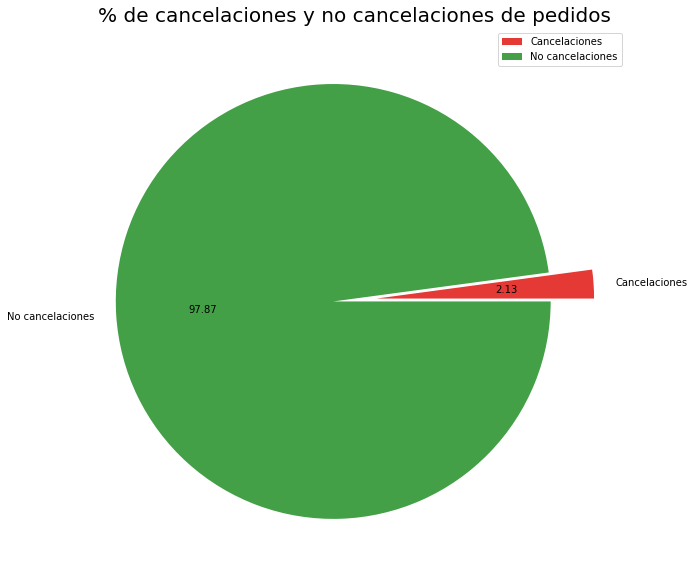

In [78]:
plt.figure(figsize=(18,10))
explode = [0.1, 0.1]
color = ["#E53935", "#43A047"]
plt.pie(df_invoiceNo["Cantidad"], labels= df_invoiceNo["Estado"], autopct="%.2f", explode=explode, colors = color)
plt.legend(loc = "best")
plt.title("% de cancelaciones y no cancelaciones de pedidos", fontsize = 20)
plt.show()

In [8]:
# Se sacan los descuentos y "manuales"
df_cancelados = df[(df.InvoiceNo.str.contains("C") == True) & ~((df.StockCode == "D") | (df.StockCode == "M"))]
df_cancelados

,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Amount_Spent,CustomerID,Country,Month,Year,Quarter,Semana,DiaSemana,Dia,yearmonth
154,C536383,2010-12-01 09:49:00,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,-4.65,15311,United Kingdom,12,2010,4,48,2,1,201012
235,C536391,2010-12-01 10:24:00,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,-19.80,17548,United Kingdom,12,2010,4,48,2,1,201012
236,C536391,2010-12-01 10:24:00,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,-6.96,17548,United Kingdom,12,2010,4,48,2,1,201012
237,C536391,2010-12-01 10:24:00,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,-6.96,17548,United Kingdom,12,2010,4,48,2,1,201012
238,C536391,2010-12-01 10:24:00,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,0.29,-6.96,17548,United Kingdom,12,2010,4,48,2,1,201012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406376,C581490,2011-12-09 09:57:00,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,1.95,-23.40,14397,United Kingdom,12,2011,4,49,4,9,201112
406377,C581490,2011-12-09 09:57:00,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,-9.13,14397,United Kingdom,12,2011,4,49,4,9,201112
406635,C581568,2011-12-09 11:57:00,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,-54.75,15311,United Kingdom,12,2011,4,49,4,9,201112
406636,C581569,2011-12-09 11:58:00,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,1.25,-1.25,17315,United Kingdom,12,2011,4,49,4,9,201112


In [25]:
df_productosC = df_cancelados.groupby("Description").agg({
    "StockCode": "count",
    "Quantity": "sum",
    "Amount_Spent": "sum"
})
# Se convierten los campos negativos a positivos
df_productosC["Quantity"] = df_productosC["Quantity"].apply(lambda x: -x)
df_productosC["Amount_Spent"] = df_productosC["Amount_Spent"].apply(lambda x: -x)

# Se seleccionan las columnas de interes
df_productosSC = df_productosC[["StockCode"]].sort_values("StockCode", ascending = False).head(10)
df_productosQ = df_productosC[["Quantity"]].sort_values("Quantity", ascending = False).head(10)
df_productosAS = df_productosC[["Amount_Spent"]].sort_values("Amount_Spent", ascending = False).head(10)

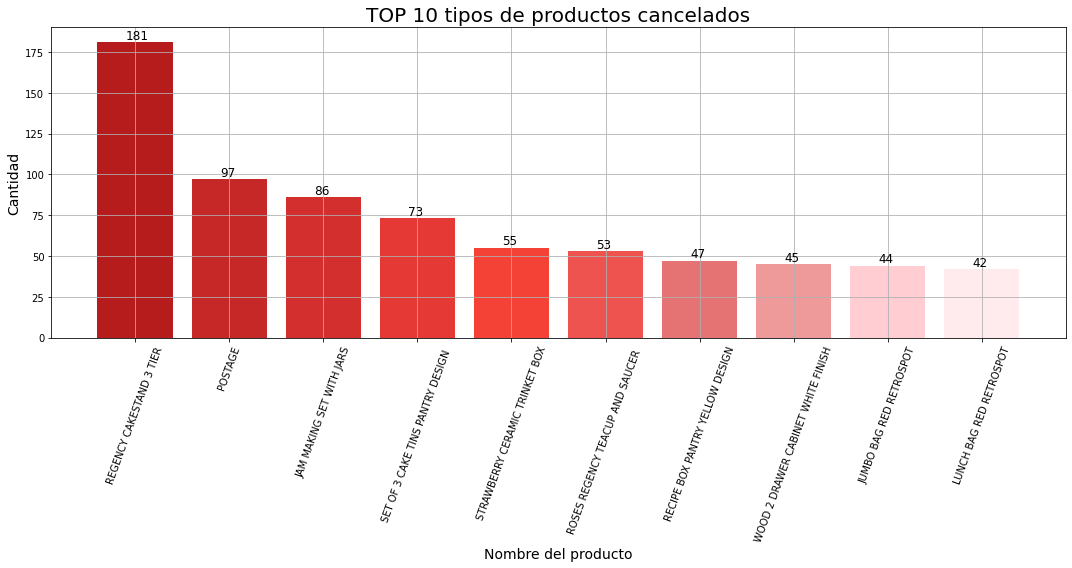

In [82]:
color_palet = ["#B71C1C", "#C62828", "#D32F2F", "#E53935", "#F44336", "#EF5350", "#E57373", "#EF9A9A", "#FFCDD2", "#FFEBEE"]
plt.figure(figsize=(15,8))
plt.grid()
plt.bar(df_productosSC.index, df_productosSC["StockCode"], color = color_palet)
plt.xticks(rotation = 70)
plt.xlabel("Nombre del producto", fontsize = 14)
plt.ylabel("Cantidad", fontsize = 14)
plt.title("TOP 10 tipos de productos cancelados", fontsize = 20)
# Se muestra la cantidad por cada barra
for index,data in enumerate(df_productosSC["StockCode"]):
    plt.text(x = index-0.098, y = data + 2, s = f"{data}", fontdict=dict(fontsize = 12))
plt.tight_layout()
plt.show()

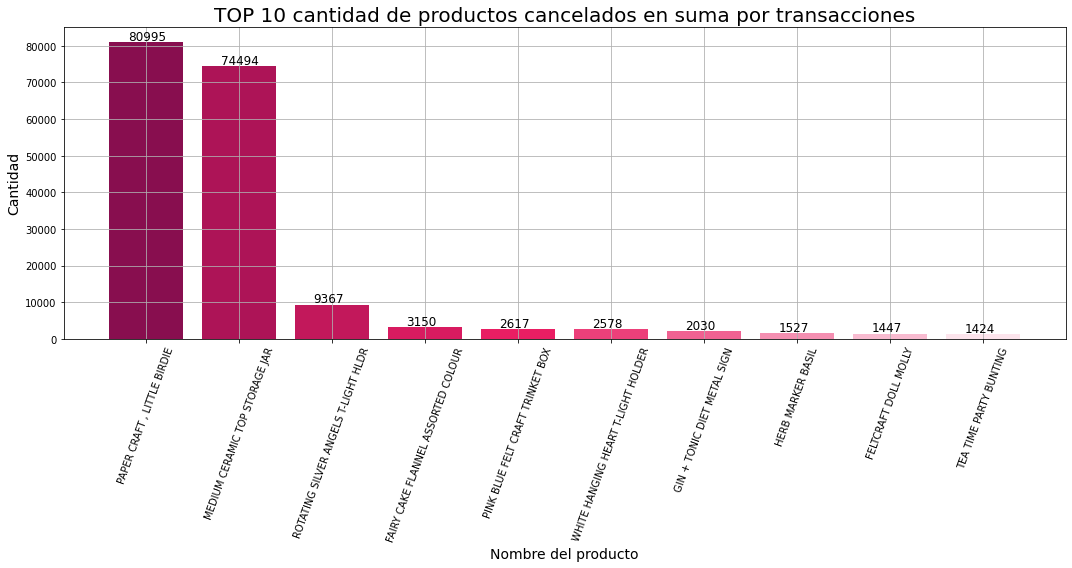

In [84]:
color_palet = ["#880E4F", "#AD1457", "#C2185B", "#D81B60", "#E91E63", "#EC407A", "#F06292", "#F48FB1", "#F8BBD0", "#FCE4EC"]
plt.figure(figsize=(15,8))
plt.grid()
plt.bar(df_productosQ.index, df_productosQ["Quantity"], color = color_palet)
plt.xticks(rotation = 70)
plt.xlabel("Nombre del producto", fontsize = 14)
plt.ylabel("Cantidad", fontsize = 14)
plt.title("TOP 10 cantidad de productos cancelados en suma por transacciones", fontsize = 20)
# Se muestra la cantidad por cada barra
for index,data in enumerate(df_productosQ["Quantity"]):
    plt.text(x = index-0.2, y = data + 500, s = f"{data}", fontdict=dict(fontsize = 12))
plt.tight_layout()
plt.show()

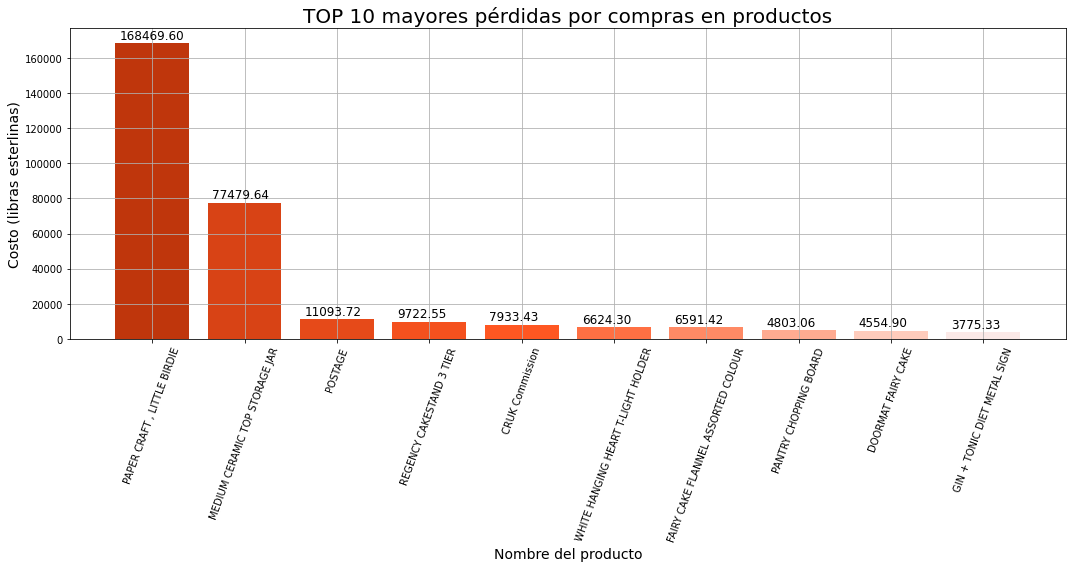

In [85]:
color_palet = ["#BF360C", "#D84315", "#E64A19", "#F4511E", "#FF5722", "#FF7043", "#FF8A65", "#FFAB91", "#FFCCBC", "#FBE9E7"]
plt.figure(figsize=(15,8))
plt.grid()
plt.bar(df_productosAS.index, df_productosAS["Amount_Spent"], color = color_palet)
plt.xticks(rotation = 70)
plt.xlabel("Nombre del producto", fontsize = 14)
plt.ylabel("Costo (libras esterlinas)", fontsize = 14)
plt.title("TOP 10 mayores pérdidas por compras en productos", fontsize = 20)
# Se muestra la cantidad por cada barra
for index,data in enumerate(df_productosAS["Amount_Spent"]):
    plt.text(x = index-0.35, y = data + 2400, s = "{0:.2f}".format(data), fontdict=dict(fontsize = 12))
plt.tight_layout()
plt.show()

In [103]:
df_paisesC = df_cancelados.groupby("Country").agg({
    "Description": "count"
})
df_paisesC = df_paisesC.sort_values("Description", ascending = False).head(10)
df_paisesC

,Description
Country,
United Kingdom,7325
Germany,446
EIRE,243
France,145
USA,112
Australia,74
Spain,45
Italy,43
Belgium,38


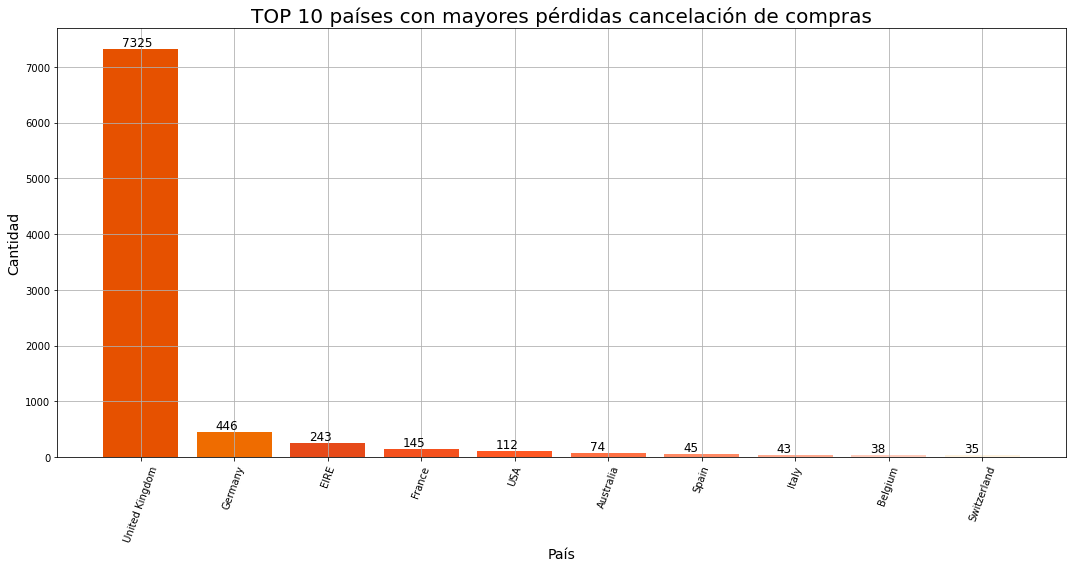

In [116]:
color_palet = ["#E65100", "#EF6C00", "#E64A19", "#F4511E", "#FF5722", "#FF7043", "#FF8A65", "#FFAB91", "#FFCCBC", "#FFF3E0"]
plt.figure(figsize=(15,8))
plt.grid()
plt.bar(df_paisesC.index, df_paisesC["Description"], color = color_palet)
plt.xticks(rotation = 70)
plt.xlabel("País", fontsize = 14)
plt.ylabel("Cantidad", fontsize = 14)
plt.title("TOP 10 países con mayores pérdidas cancelación de compras", fontsize = 20)
# Se muestra la cantidad por cada barra
for index,data in enumerate(df_paisesC["Description"]):
    plt.text(x = index-0.2, y = data + 50, s = data, fontdict=dict(fontsize = 12))
plt.tight_layout()
plt.show()

- Listar productos favoritos de clientes
- Horario específico en que los clientes compran. Sugerencia de horario para aumentar capacidad
- Frecuencia de compra de los clientesde alta frecuencia. Cuánto debería gastar un cliente para considerarlo sobre la media.
- Cómo distribuye la antigüedad de los clientes 
- Clusterizacion en 3 en base a la frecuencia de compra (kmeans)

## Lista de productos favoritos comprados por los clientes
Primero se extraen del total de registros del data set, aquellos que no correspondan a devoluciones o cancelaciones de compras, esta regla se cumple cuando la variable del número de factura (InvoiceNo) no contiene una letra C. Posterior a esto, se agrupa por descripción de producto y se cuenta la cantidad de éstos que están repetidos, se suman las cantidades compradas en transacciones por cada caso y se suman los costos totales por cada caso en transacciones, para finalmente elegir el TOP 10 por cada uno.

In [5]:
df_compras = df[~(df.InvoiceNo.str.contains("C") == True)]
df_compras.head()

,InvoiceNo,InvoiceDate,StockCode,Description,Quantity,UnitPrice,Amount_Spent,CustomerID,Country,Month,Year,Quarter,Semana,DiaSemana,Dia,NombreDia,Date,Yearmonth,Hour
0,536365,2010-12-01 08:26:00,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,17850,United Kingdom,12,2010,4,48,2,1,Wednesday,2010-12-01,2010-12,8
1,536365,2010-12-01 08:26:00,71053,WHITE METAL LANTERN,6,3.39,20.34,17850,United Kingdom,12,2010,4,48,2,1,Wednesday,2010-12-01,2010-12,8
2,536365,2010-12-01 08:26:00,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,17850,United Kingdom,12,2010,4,48,2,1,Wednesday,2010-12-01,2010-12,8
3,536365,2010-12-01 08:26:00,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,17850,United Kingdom,12,2010,4,48,2,1,Wednesday,2010-12-01,2010-12,8
4,536365,2010-12-01 08:26:00,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,17850,United Kingdom,12,2010,4,48,2,1,Wednesday,2010-12-01,2010-12,8


In [6]:
df_compras.describe()

,Quantity,UnitPrice,Amount_Spent,CustomerID,Month,Year,Quarter,Semana,DiaSemana,Dia,Hour
count,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,22.394749,15294.315171,7.612537,2010.934259,2.856106,30.964629,2.614555,15.042181,12.728247
std,180.420210,22.096788,309.055588,1713.169877,3.416527,0.247829,1.121873,14.755880,1.928274,8.653771,2.273535
min,1.000000,0.000000,0.000000,12346.000000,1.000000,2010.000000,1.000000,1.000000,0.000000,1.000000,6.000000
25%,2.000000,1.250000,4.680000,13969.000000,5.000000,2011.000000,2.000000,19.000000,1.000000,7.000000,11.000000
50%,6.000000,1.950000,11.800000,15159.000000,8.000000,2011.000000,3.000000,34.000000,2.000000,15.000000,13.000000
75%,12.000000,3.750000,19.800000,16795.000000,11.000000,2011.000000,4.000000,44.000000,4.000000,22.000000,14.000000
max,80995.000000,8142.750000,168469.600000,18287.000000,12.000000,2011.000000,4.000000,51.000000,6.000000,31.000000,20.000000


In [19]:
# Se agrupan por el nombre del producto e id unico de cliente
df_productos = pd.DataFrame(df_compras.groupby("Description")["CustomerID"].nunique()) 
# Se reseta inde
df_productos = df_productos.reset_index().sort_values("CustomerID", ascending=False)
# Se crea un código unico asociado al producto (optimizar espacios en el grafico)
df_productos["Description_code"] = df_productos["Description"].astype("category").cat.codes
df_productos["Description_code"] = df_productos["Description_code"].astype(str)
df_productos

,Description,CustomerID,Description_code
2767,REGENCY CAKESTAND 3 TIER,881,2767
3698,WHITE HANGING HEART T-LIGHT HOLDER,856,3698
2345,PARTY BUNTING,708,2345
216,ASSORTED COLOUR BIRD ORNAMENT,678,216
3001,SET OF 3 CAKE TINS PANTRY DESIGN,640,3001
...,...,...,...
278,BAROQUE BUTTERFLY EARRINGS CRYSTAL,1,278
2639,PURPLE FRANGIPANI HAIRCLIP,1,2639
2839,ROCOCO WALL MIROR,1,2839
2643,PURPLE GLASS TASSLE BAG CHARM,1,2643


In [48]:
labels=  {
    "Description" : "Nombre producto ", 
    "Description_code": "Código del producto ",
    "CustomerID" : "Cantidad de compras "
}

title= {"text":"Top 10 de productos más comprados", "x": 0.5}

fig = px.bar(df_productos.head(10), 
             x = "CustomerID", 
             y = "Description_code", 
             hover_data=['Description'],
             text="Description",
             orientation = "h", 
             labels = labels)
fig.update_traces(marker_color='#C5CAE9', 
                  marker_line_color='#1A237E',
                  marker_line_width=1.5, 
                  opacity=0.6,
                  textfont_color="black")
fig.update_layout(title=title)
fig.show()

Horario específico de compra

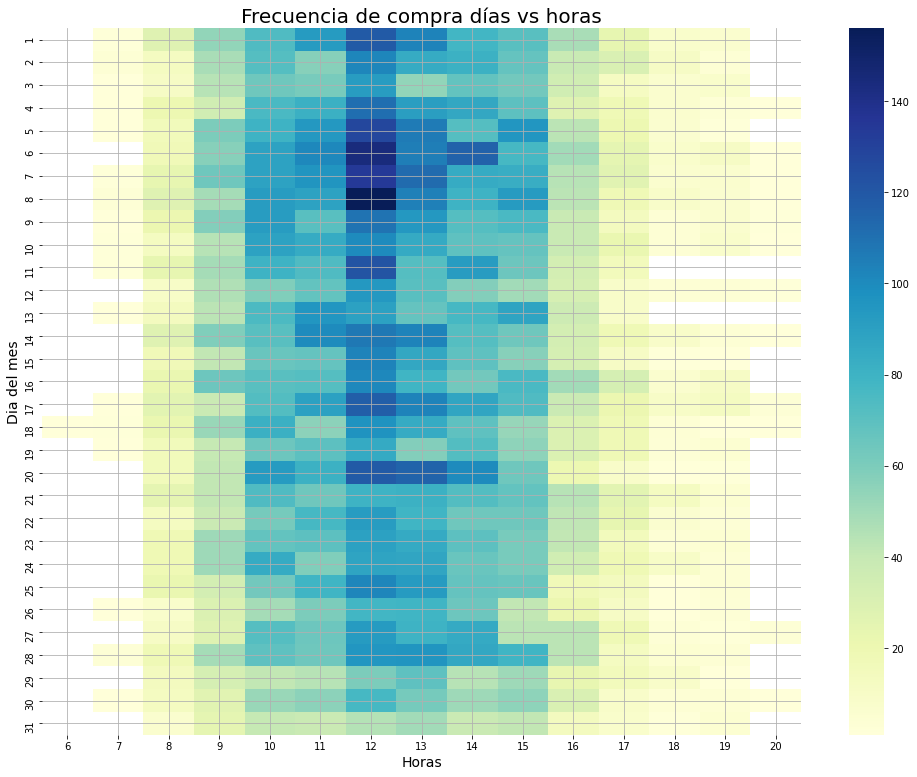

In [10]:
# Se agrupa por dia y hora la cantidad de facturas UNICAS ocurridas y se almcanena como arreglo
grouped_data_new  = df_compras.groupby(["Dia", "Hour"])["InvoiceNo"].unique().reset_index()
# Del dato agrupado se cuenta la cantidad de transaccioens que hubo
grouped_data_new["InvoiceNo"] = grouped_data_new["InvoiceNo"].apply(len)
# Se deja como indice de la matriz los dias y las horas para posterior rellenar esta con la cantidad de transacciones
grouped_data_new = grouped_data_new.pivot('Dia', 'Hour', 'InvoiceNo')

# Se instancia mapa de calor de las horas con mas transacciones respecto a los dias
plt.figure(figsize=(17,13))
sns.heatmap(grouped_data_new, cmap="YlGnBu")
plt.title("Frecuencia de compra días vs horas" , fontsize = 20)
plt.xlabel("Horas", fontsize = 14)
plt.ylabel("Dia del mes", fontsize = 14)
plt.grid()
plt.show()

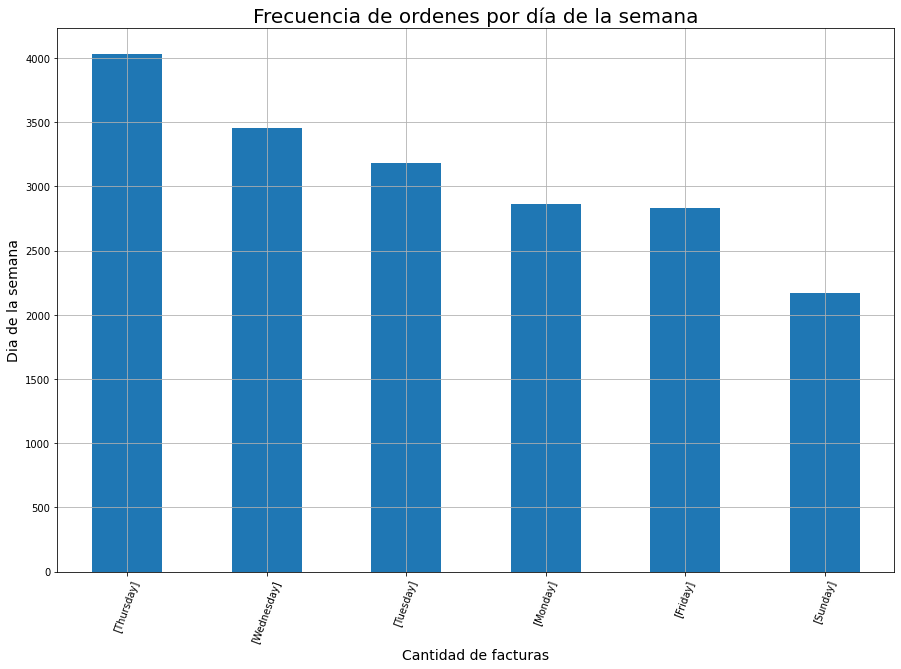

In [11]:
# Se agrupa la cantidad de facturas UNICAS por dia
InvoiceDate = df_compras.groupby(['InvoiceNo'])['NombreDia'].unique()
dfm =  InvoiceDate.value_counts().sort_index( ascending=True)
dfm.to_frame().sort_values("NombreDia", ascending = False).plot.bar(figsize=(15,10), legend=None)
plt.title("Frecuencia de ordenes por día de la semana", fontsize=20)
plt.xlabel("Cantidad de facturas", fontsize = 14)
plt.ylabel("Dia de la semana", fontsize = 14)
plt.xticks(rotation = 70)
plt.grid()
plt.show()

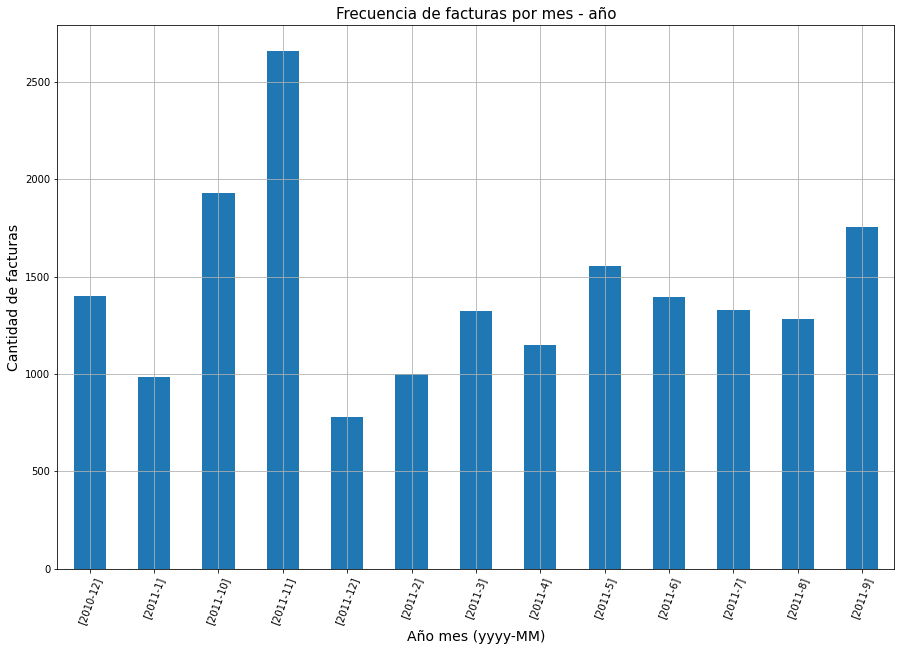

In [12]:
# Grafico de numero de factoras por mes - año
plt.figure(figsize=(15,10))
InvoiceDate = df_compras.groupby(['InvoiceNo'])['Yearmonth'].unique()
InvoiceDate.value_counts().sort_index().plot.bar()
plt.title("Frecuencia de facturas por mes - año", fontsize=15)
plt.xlabel("Año mes (yyyy-MM)", fontsize = 14)
plt.ylabel("Cantidad de facturas", fontsize = 14)
plt.xticks(rotation = 70)
plt.grid()
plt.show()

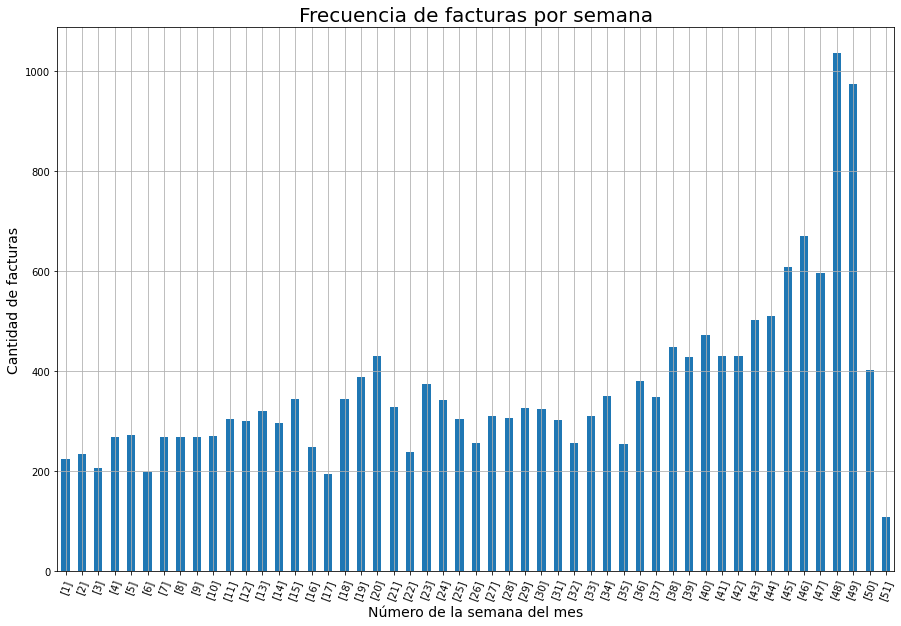

In [14]:
plt.figure(figsize=(15,10))
InvoiceDate = df_compras.groupby(['InvoiceNo'])['Semana'].unique()
InvoiceDate.value_counts().sort_index().plot.bar()
plt.title("Frecuencia de facturas por semana", fontsize=20)
plt.xlabel("Número de la semana del mes", fontsize = 14)
plt.ylabel("Cantidad de facturas", fontsize = 14)
plt.xticks(rotation = 70)
plt.grid()
plt.show()

## RFM
Se aplica una segmentación RFM para alcanzar el grupo específico de consumidores, basados en el historial de transacciones de los clientes:
- Ultima compra
- Frecuencia de compra
- Gasto en la última compra

<br>

- R: recencia, días desde la última compra realizada
- F: frecuencia, total de compras realizadas
- M: monetario, valor de la compra realizada

La segmentación RFM se basa en el principio de que el 80% de los ingresos proviene del 20% de los clientes. Para esto se trabaja con puntajes de cuantiles.

### Cálculo de la Recencia (días desde la última compra realizada)

In [15]:
# En un nuevo DF se agrupan los consumidores (CustomerID) según su última compra
recency_df_compras = df_compras.groupby(by='CustomerID', as_index=False)['Date'].max()
# Se crean las columnas asociadas a los campos nuevos
recency_df_compras.columns = ['CustomerID','LastPurchaseDate']
recency_df_compras.head()

,CustomerID,LastPurchaseDate
0,12346,2011-01-18
1,12347,2011-12-07
2,12348,2011-09-25
3,12349,2011-11-21
4,12350,2011-02-02


In [16]:
# Se obtiene el rango de fechas que abarca el set de datos
print("Fecha de inicio: ", df_compras["InvoiceDate"].dt.date.min())
print("Fecha de término: ", df_compras["InvoiceDate"].dt.date.max())

Fecha de inicio:  2010-12-01
Fecha de término:  2011-12-09


Se sabe que la última compra se realizó el 09-12-2011, por lo que se emplea esta última para calcular el recencia

In [17]:
# Se calcula la recencia en días, en base a la fecha de la ultima compra menos la fecha de la compra del cliente
recency_df_compras['Recency'] = recency_df_compras['LastPurchaseDate'].apply(lambda x: (df_compras["InvoiceDate"].dt.date.max() - x.date()).days)
recency_df_compras

,CustomerID,LastPurchaseDate,Recency
0,12346,2011-01-18,325
1,12347,2011-12-07,2
2,12348,2011-09-25,75
3,12349,2011-11-21,18
4,12350,2011-02-02,310
...,...,...,...
4334,18280,2011-03-07,277
4335,18281,2011-06-12,180
4336,18282,2011-12-02,7
4337,18283,2011-12-06,3


### Cálculo de la frecuencia 

In [50]:
# Se realiza una copia del dataset de compras
frequency_data = df_compras.copy()
# Se eliminan los datos duplicados que esten sobre el numero de factura y el id de cliente
frequency_data.drop_duplicates(subset=['CustomerID','InvoiceNo'], keep="first", inplace=True) 
frequency_data.shape

(18536, 19)

In [51]:
# Se agrupa por id y se cuenta la cantidad de numero de facturas por cliente
frequency_df_compras = frequency_data.groupby('CustomerID',as_index=False)['InvoiceNo'].count()
# Se asignan los nombres a las columnas
frequency_df_compras.columns = ['CustomerID','Frequency']
frequency_df_compras

,CustomerID,Frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1
...,...,...
4334,18280,1
4335,18281,1
4336,18282,2
4337,18283,16


### Cálculo del monetario

In [52]:
# Se suma todo el gasto por cada id de cliente
monetary_df_compras = df_compras.groupby('CustomerID',as_index=False)['Amount_Spent'].sum()
monetary_df_compras.columns = ['CustomerID','Monetary']
monetary_df_compras

,CustomerID,Monetary
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40
...,...,...
4334,18280,180.60
4335,18281,80.82
4336,18282,178.05
4337,18283,2094.88


Se combinan los 3 dataset creados asociados a la segmentacion RFM

In [53]:
#combinar recency, frecuency, monetary
rf = recency_df_compras.merge(frequency_df_compras, left_on='CustomerID', right_on='CustomerID')
rfm = rf.merge(monetary_df_compras, left_on='CustomerID', right_on='CustomerID' )
# Se borra la columna de la ultima fecha de compra
del rfm["LastPurchaseDate"]
# Se deja el id de cliente como indice del dataset
rfm.set_index('CustomerID',inplace=True)
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,178.05


In [54]:
#separarar en cuantiles, para obtener las fronteras
quantile = rfm.quantile(q=[0.25, 0.5, 0.75])
quantile

,Recency,Frequency,Monetary
0.25,17.0,1.0,307.245
0.50,50.0,2.0,674.450
0.75,141.5,5.0,1661.640


In [55]:
# Definir score (x = valor, p = recency, monetary, frequency, d= cuartil)
# valor bajo en recency es bueno para la tienda
def RScore(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Definir score (x = valor, p = recency, monetary, frequency, d= cuartil)
# alto valor en monetary y frequency es bueno para la tienda
def FMScore(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [56]:
# Se determina el cuartil al que pertenecen en cada categoría de RFM
rfm['R_Quantile'] = rfm['Recency'].apply(RScore, args=('Recency', quantile))
rfm['F_Quantile'] = rfm['Frequency'].apply(FMScore, args=('Frequency', quantile))
rfm['M_Quantile'] = rfm['Monetary'].apply(FMScore, args=('Monetary', quantile))

In [57]:
#calcular el RFM score
rfm['RFMScore'] = rfm.R_Quantile.map(str) \
                            + rfm.F_Quantile.map(str) \
                            + rfm.M_Quantile.map(str)
rfm

,Recency,Frequency,Monetary,R_Quantile,F_Quantile,M_Quantile,RFMScore
CustomerID,,,,,,,
12346,325,1,77183.60,4,4,1,441
12347,2,7,4310.00,1,1,1,111
12348,75,4,1797.24,3,2,1,321
12349,18,1,1757.55,2,4,1,241
12350,310,1,334.40,4,4,3,443
...,...,...,...,...,...,...,...
18280,277,1,180.60,4,4,4,444
18281,180,1,80.82,4,4,4,444
18282,7,2,178.05,1,3,4,134


In [62]:
rfm.describe()

,Recency,Frequency,Monetary,R_Quantile,F_Quantile,M_Quantile
count,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000,4339.000000
mean,92.041484,4.271952,2053.793018,2.493893,2.680111,2.500115
std,100.007757,7.705493,8988.248381,1.122159,1.143869,1.118266
min,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,17.000000,1.000000,307.245000,1.000000,2.000000,1.500000
50%,50.000000,2.000000,674.450000,2.000000,3.000000,3.000000
75%,141.500000,5.000000,1661.640000,3.500000,4.000000,3.500000
max,373.000000,210.000000,280206.020000,4.000000,4.000000,4.000000


In [63]:
print("===================================================================")
print("Tamaño del dataframe:")
print(rfm.shape)
print("===================================================================")
print("Tipo de variable de las columnas:")
print(rfm.dtypes)
print("===================================================================")

Tamaño del dataframe:
(4339, 7)
Tipo de variable de las columnas:
Recency         int64
Frequency       int64
Monetary      float64
R_Quantile      int64
F_Quantile      int64
M_Quantile      int64
RFMScore       object
dtype: object


Se obtiene cierta clasificación de la cantidad de clientes

In [68]:
df_clientes_frecuentes = rfm[rfm['F_Quantile'] == 1]
promedio_frecuencia = df_clientes_frecuentes["Frequency"].mean()
print("Cantidad de clientes más frecuentes: ", len(df_clientes_frecuentes))
print("Frecuencia promedio de compra de estos clientes: {:.2f} compras".format(promedio_frecuencia))

Cantidad de clientes más frecuentes:  872
Frecuencia promedio de compra de estos clientes: 12.71 compras


In [58]:
print("Mejores Clientes: ",len(rfm[rfm['RFMScore']=='111']))
print('Clientes Leales: ',len(rfm[rfm['F_Quantile']==1]))
print("Grandes Gastadores: ",len(rfm[rfm['M_Quantile']==1]))
print('Casi Perdidos: ', len(rfm[rfm['RFMScore']=='134']))
print('Clientes Perdidos: ',len(rfm[rfm['RFMScore']=='344']))
print('Clientes Baratos Perdidos: ',len(rfm[rfm['RFMScore']=='444']))

Mejores Clientes:  456
Clientes Leales:  872
Grandes Gastadores:  1085
Casi Perdidos:  34
Clientes Perdidos:  208
Clientes Baratos Perdidos:  443


## Análisis de distribuciones
De acuerdo al último dataset generado por segmentación RFM se realiza un histograma para la recencia, frecuencia y el consumo monetario.

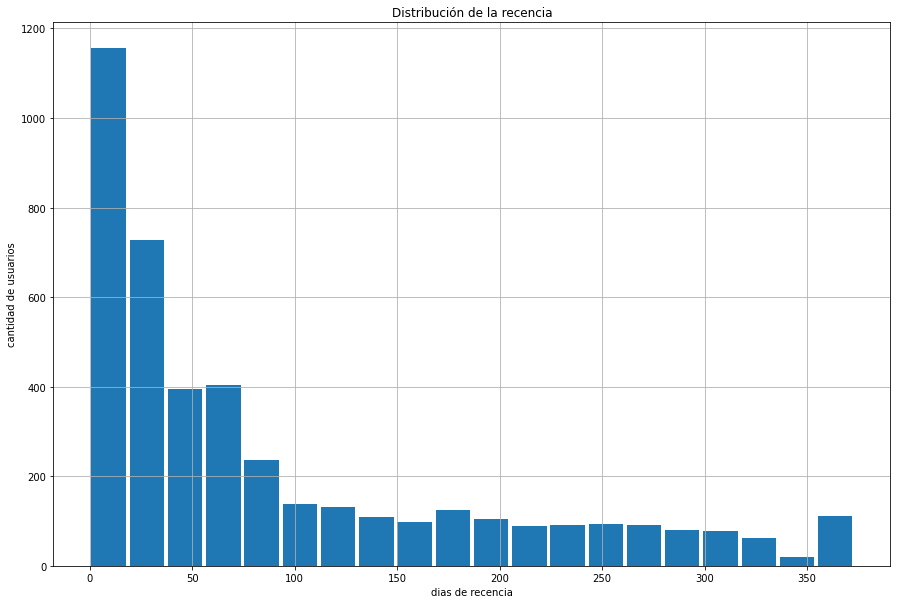

In [59]:
plt.figure(figsize=(15,10))
plt.hist(rfm["Recency"], rwidth = 0.9, bins = 20)
plt.title("Distribución de la recencia")
plt.grid()
plt.xlabel("dias de recencia")
plt.ylabel("cantidad de usuarios")
plt.show()

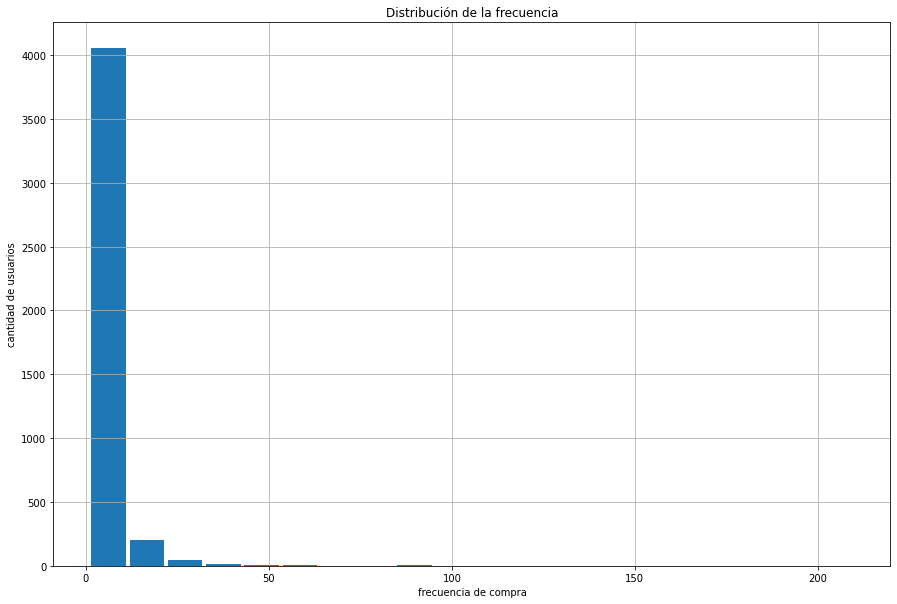

In [60]:
plt.figure(figsize=(15,10))
plt.hist(rfm["Frequency"], rwidth = 0.9, bins = 20)
plt.title("Distribución de la frecuencia")
plt.grid()
plt.xlabel("frecuencia de compra")
plt.ylabel("cantidad de usuarios")
plt.show()

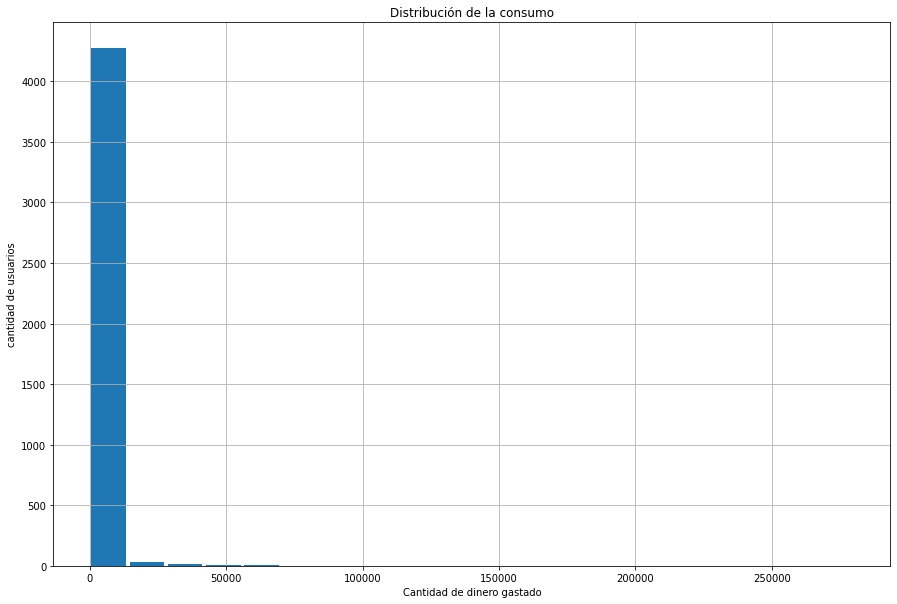

In [61]:
plt.figure(figsize=(15,10))
plt.hist(rfm["Monetary"], rwidth = 0.9, bins = 20)
plt.title("Distribución de la consumo")
plt.grid()
plt.xlabel("Cantidad de dinero gastado")
plt.ylabel("cantidad de usuarios")
plt.show()

### Clusterización de clientes en base a la frecuencia de compra

In [131]:
# Se extraen las columnas de interes
df_clustering = rfm[["Recency", "Frequency", "Monetary"]]
df_clustering

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,178.05


In [132]:
# Se estandarizan las variables
df_clustering_std = stats.zscore(df_clustering)
df_clustering_std.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Recency,Frequency,Monetary
count,4339.00000,4339.00000,4339.00000
mean,-0.00000,0.00000,-0.00000
std,1.00012,1.00012,1.00012
min,-0.92045,-0.42467,-0.22852
25%,-0.75044,-0.42467,-0.19434
50%,-0.42043,-0.29488,-0.15348
75%,0.49460,0.09450,-0.04363
max,2.80969,26.70196,30.94978


In [133]:
# Se crea la matriz de distancias para kmeans
pd.DataFrame(distance_matrix(df_clustering_std.values, df_clustering_std.values), index=df_clustering_std.index, columns = df_clustering_std.index)

CustomerID,12346,12347,12348,12349,12350,12352,12353,12354,12355,12356,...,18273,18274,18276,18277,18278,18280,18281,18282,18283,18287
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,0.000000,8.762953,8.761487,8.936514,8.552265,8.844369,8.663179,8.518973,8.608906,8.816468,...,9.157956,9.062217,9.003830,8.981931,8.931705,8.581498,8.700847,9.140381,9.163330,8.852329
12347,8.762953,0.000000,0.873343,0.844229,3.207687,0.415627,2.215345,2.454806,2.298863,0.580814,...,0.691570,0.946817,0.984943,1.066978,1.149957,2.894935,1.999135,0.796888,1.193894,0.710810
12348,8.761487,0.873343,0.000000,0.690332,2.387682,0.654117,1.360871,1.619593,1.451213,0.557227,...,0.762374,0.621832,0.529588,0.464485,0.429699,2.065110,1.136078,0.749853,1.716209,0.354647
12349,8.936514,0.844229,0.690332,0.000000,2.924400,0.929945,1.869313,2.141410,1.965389,0.287638,...,0.350525,0.213008,0.295853,0.440004,0.577558,2.596034,1.630768,0.244612,1.953019,0.353649
12350,8.552265,3.207687,2.387682,2.924400,0.000000,2.896897,1.060392,0.784422,0.960137,2.904888,...,3.091069,2.800161,2.670101,2.520218,2.370157,0.330456,1.300355,3.032943,3.640653,2.697831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,8.581498,2.894935,2.065110,2.596034,0.330456,2.588619,0.730099,0.460996,0.630787,2.579935,...,2.762329,2.470093,2.340152,2.190096,2.040077,0.000000,0.970100,2.703219,3.368072,2.371557
18281,8.700847,1.999135,1.136078,1.630768,1.300355,1.723959,0.240011,0.531758,0.342612,1.629812,...,1.798947,1.500094,1.370345,1.220050,1.070090,0.970100,0.000000,1.734961,2.640782,1.417789
18282,9.140381,0.796888,0.749853,0.244612,3.032943,0.870439,1.974370,2.256055,2.074379,0.353843,...,0.139121,0.264103,0.383098,0.526329,0.672666,2.703219,1.734961,0.000000,1.830007,0.416462


In [134]:
# Se crea la instancia de kmeans para 3 cluster
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_clustering_std)
# Se muestran los centroides de cada cluster
cetroides = kmeans.cluster_centers_
print(cetroides)

[[-0.86583208  8.07673458  9.32998501]
 [ 1.54086676 -0.34921133 -0.15823447]
 [-0.51221653  0.05257211 -0.0218781 ]]


In [135]:
# Se crean los cluster para cada registro del dataset y posteriormente se añaden como nueva columna del df_clustering_std
Cluster = kmeans.fit_predict(df_clustering_std)
df_clustering_std['Cluster'] = Cluster
df_clustering_std.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,2.329673,-0.424675,8.359634,1
12347,-0.900449,0.354080,0.251046,2
12348,-0.170421,-0.035297,-0.028546,2
12349,-0.740443,-0.424675,-0.032963,2
12350,2.179667,-0.424675,-0.191315,1


In [136]:
# Se añade la coordenada de centroide para cada cluster
df_clustering_std.loc[df_clustering_std['Cluster']==0,'Cen_x']=cetroides[0][0]
df_clustering_std.loc[df_clustering_std['Cluster']==1,'Cen_x']=cetroides[1][0]
df_clustering_std.loc[df_clustering_std['Cluster']==2,'Cen_x']=cetroides[2][0]

df_clustering_std.loc[df_clustering_std['Cluster']==0,'Cen_y']=cetroides[0][1]
df_clustering_std.loc[df_clustering_std['Cluster']==1,'Cen_y']=cetroides[1][1]
df_clustering_std.loc[df_clustering_std['Cluster']==2,'Cen_y']=cetroides[2][1]

df_clustering_std.loc[df_clustering_std['Cluster']==0,'Cen_z']=cetroides[0][2]
df_clustering_std.loc[df_clustering_std['Cluster']==1,'Cen_z']=cetroides[1][2]
df_clustering_std.loc[df_clustering_std['Cluster']==2,'Cen_z']=cetroides[2][2]
df_clustering_std

,Recency,Frequency,Monetary,Cluster,Cen_x,Cen_y,Cen_z
CustomerID,,,,,,,
12346,2.329673,-0.424675,8.359634,1,1.540867,-0.349211,-0.158234
12347,-0.900449,0.354080,0.251046,2,-0.512217,0.052572,-0.021878
12348,-0.170421,-0.035297,-0.028546,2,-0.512217,0.052572,-0.021878
12349,-0.740443,-0.424675,-0.032963,2,-0.512217,0.052572,-0.021878
12350,2.179667,-0.424675,-0.191315,1,1.540867,-0.349211,-0.158234
...,...,...,...,...,...,...,...
18280,1.849655,-0.424675,-0.208429,1,1.540867,-0.349211,-0.158234
18281,0.879618,-0.424675,-0.219531,1,1.540867,-0.349211,-0.158234
18282,-0.850447,-0.294882,-0.208712,2,-0.512217,0.052572,-0.021878


In [137]:
# Se agrupa por cluster para observar las caracteristicas de cada caso
dataAgrupado = df_clustering_std.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean"
})
dataAgrupado

,Recency,Frequency,Monetary
Cluster,,,
0,-0.865832,8.076735,9.329985
1,1.540867,-0.349211,-0.158234
2,-0.512217,0.052572,-0.021878


Se puede apreciar las siguientes características de los cluster en función de los promedios:
- Grupo 0: clientes de muy alta frecuencia (Frecuency = 8.076735)
- Grupo 1: clientes de baja frecuencia (Frecuency = -0.349211)
- Grupo 2: clientes de frecuencia promedio (Frecuency = 0.052572)

<br>

En base a estas descripciónes, los nombres que se le colocan a cada cluster son los siguientes:
- Cluster 0: clientes muy frecuentes
- Cluster 1: clientes poco frecuentes
- Cluster 2: clientes frecuencia promedio

In [138]:
# Se añade el nombre al cluster
cluster_tag = {0 : "Clientes muy frecuentes", 1 : "Clientes poco frecuentes", 2:"Clientes frecuencia promedio"}
df_clustering_std = df_clustering_std.replace({"Cluster" : cluster_tag})
df_clustering_std.head()

,Recency,Frequency,Monetary,Cluster,Cen_x,Cen_y,Cen_z
CustomerID,,,,,,,
12346,2.329673,-0.424675,8.359634,Clientes poco frecuentes,1.540867,-0.349211,-0.158234
12347,-0.900449,0.354080,0.251046,Clientes frecuencia promedio,-0.512217,0.052572,-0.021878
12348,-0.170421,-0.035297,-0.028546,Clientes frecuencia promedio,-0.512217,0.052572,-0.021878
12349,-0.740443,-0.424675,-0.032963,Clientes frecuencia promedio,-0.512217,0.052572,-0.021878
12350,2.179667,-0.424675,-0.191315,Clientes poco frecuentes,1.540867,-0.349211,-0.158234


In [139]:
labels=  {
    "Recency" : "Nivel de recencia ", 
    "Frequency": "Nivel de frecuencia ",
    "Monetary" : "Nivel de consumo ",
    "Cluster" : "Grupo "
}
fig = px.scatter_3d(df_clustering_std, 
                    x='Recency', 
                    y='Frequency', 
                    z='Monetary',
                    hover_data=['Cluster'],
                    color='Cluster',
                    symbol='Cluster',
                    labels = labels)
fig.show()